# 1.Camera Calibration

In [78]:
#set your chessboard size to 9x6 for the project
import matplotlib.image as mpimg
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,5,0)
objp = np.zeros((9*6,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

#read images
images = glob.glob('camera_cal/calibration*.jpg')
for idx,image in enumerate(images):
    #gray transform
    img = mpimg.imread(image)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    #find chessboard
    nx,ny = 9,6
    ret,corners = cv2.findChessboardCorners(gray,(nx,ny),None)
    if ret==True:
        objpoints.append(objp)
        imgpoints.append(corners)
        #draw chessboard,optional
        draw = cv2.drawChessboardCorners(img,(nx,ny),corners,ret)

#camera calibration
ret,mtx,dist,rvecs,tvecs = cv2.calibrateCamera(objpoints,imgpoints,gray.shape[::-1],None,None)

# 2.Distortion correction

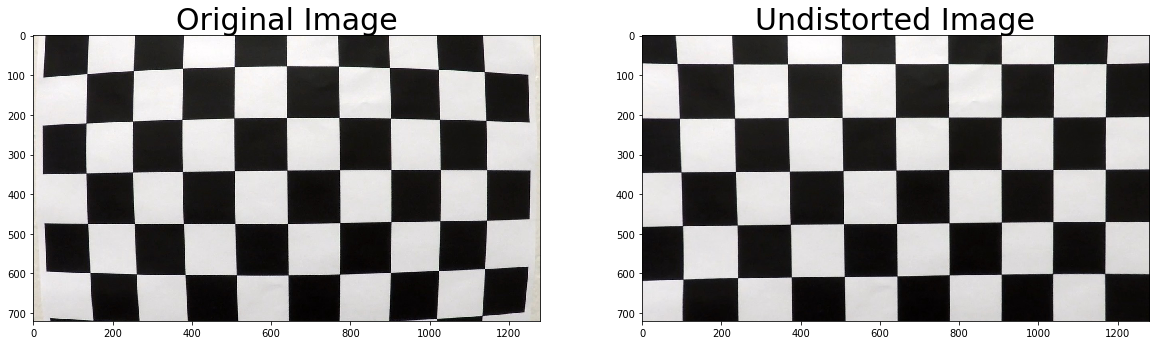

In [79]:
#undistorting the images
img = mpimg.imread('camera_cal/calibration1.jpg')
dst = cv2.undistort(img,mtx,dist,None,mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
plt.show()

# 3.Color/Gradient threshold

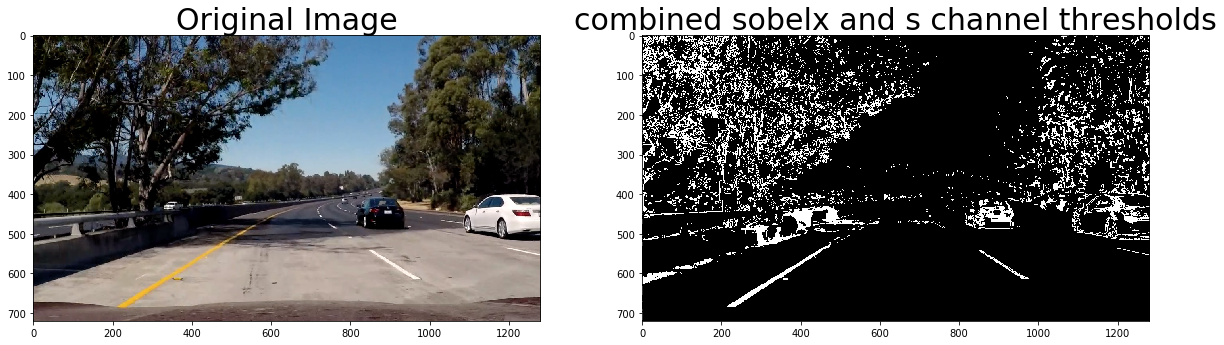

In [80]:
# Read in an image
image = mpimg.imread('test_images/test5.jpg')

def sobel_threshold(img, sobel_kernel=3, orient='x',thresh=(0,255)):
     # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel_val = cv2.Sobel(gray,cv2.CV_64F,1,0)
    elif orient == 'y': 
        sobel_val = cv2.Sobel(gray,cv2.CV_64F,0,1)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel_val)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    # 6) Return this mask as your binary_output image
    binary_output[(scaled_sobel>thresh[0])&(scaled_sobel<thresh[1])] = 1
    return binary_output

def hls_threshold(img,channel='s',thresh=(0,255)):
    hls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    if channel == 'h':
        channel_val = hls[:,:,0]
    elif channel == 'l':
        channel_val = hls[:,:,1]
    elif channel == 's':
        channel_val = hls[:,:,2]
    #scaled_channel = np.uint8(255*channel_val*1.0/np.max(channel_val))
    scaled_channel = channel_val
    binary = np.zeros_like(scaled_channel)
    binary[(scaled_channel>thresh[0])&(scaled_channel<=thresh[1])]=1
    return binary


# Run the function
def sobel_hls_threshold(img,sobel_kernel,orient,sobel_thresh,hls_thresh):
    dir_binary = sobel_threshold(img, sobel_kernel=3,orient='x',thresh=sobel_thresh)
    channel_binary = hls_threshold(img,channel='s',thresh=hls_thresh)
    result_binary = np.zeros_like(channel_binary)
    result_binary[(dir_binary==1)|(channel_binary==1)]=1
    return result_binary
#the result
res = sobel_hls_threshold(image,sobel_kernel=3,orient='x',sobel_thresh=(60,150),hls_thresh=(150,255))

# Visualize threshold result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image,cmap = 'gray')
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(res,cmap = 'gray')
ax2.set_title('combined sobelx and s channel thresholds', fontsize=30)
plt.show()

# 4.Perspective transform

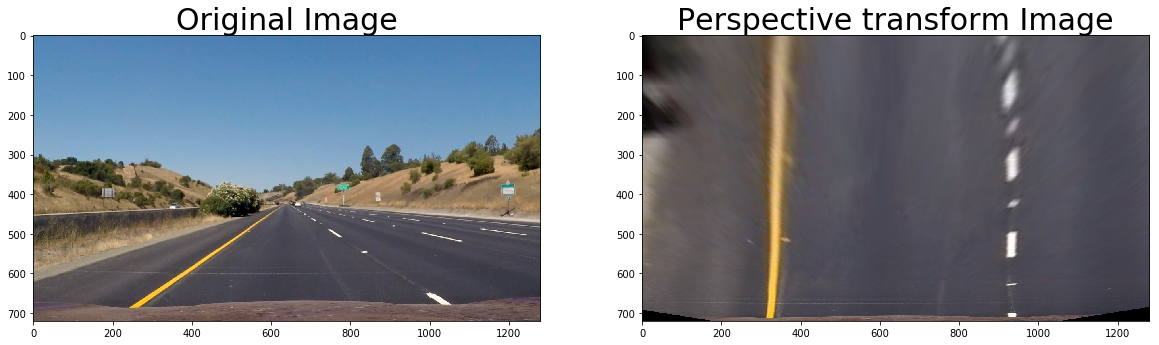

In [81]:
#read image
image = mpimg.imread('test_images/straight_lines1.jpg')

src = np.float32([[197,720],[1142,720],[680,445],[599,445]])
dst = np.float32([[317,720],[955,720],[955,0],[317,0]])
M = cv2.getPerspectiveTransform(src,dst)
Minv =cv2.getPerspectiveTransform(dst,src)
#warp images
img_size = (image.shape[1],image.shape[0])
warped = cv2.warpPerspective(image,M,img_size)

# Visualize threshold result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image,cmap = 'gray')
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(warped,cmap = 'gray')
ax2.set_title('Perspective transform Image', fontsize=30)
plt.show()

# 5.Test perspective transform

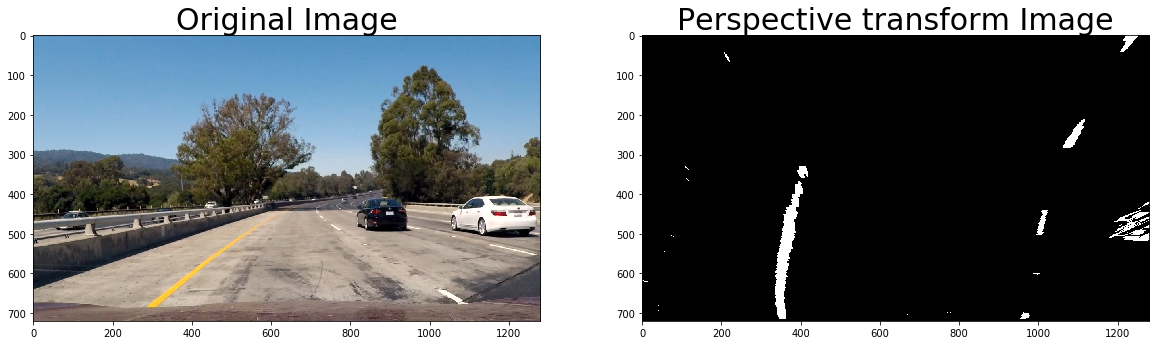

In [82]:
#read image    
image = mpimg.imread('test_images/test1.jpg')

#undistort image
undist_image = cv2.undistort(image,mtx,dist,None,mtx)
#sobelx and hls threshold
thresh_image = sobel_hls_threshold(undist_image,sobel_kernel=3,orient='x',sobel_thresh=(55,150),hls_thresh=(150,255))
#warp images
img_size = (image.shape[1],image.shape[0])
warped_image = cv2.warpPerspective(thresh_image,M,img_size)

# Visualize threshold result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image,cmap = 'gray')
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(warped_image,cmap = 'gray')
ax2.set_title('Perspective transform Image', fontsize=30)
plt.show()

# 5.Detect lane lines

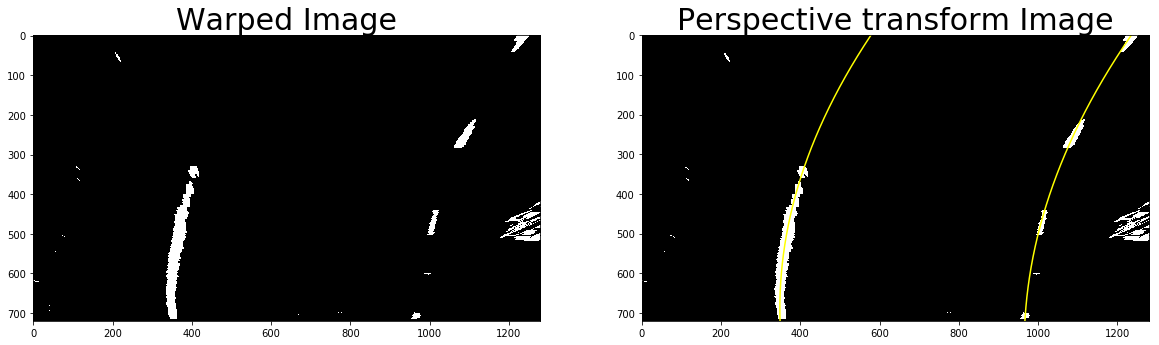

In [83]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def detect_line(warped_image,nwindows=9,margin=100,minpix=40):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(warped_image[warped_image.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((warped_image, warped_image, warped_image))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    #nwindows = 9
    # Set height of windows
    window_height = np.int(warped_image.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    #margin = 100
    # Set minimum number of pixels found to recenter window
    #minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped_image.shape[0] - (window+1)*window_height
        win_y_high = warped_image.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, warped_image.shape[0]-1, warped_image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return left_fit,right_fit,left_fitx,right_fitx

#visualization
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(warped_image,cmap = 'gray')
ax1.set_title('Warped Image', fontsize=30)

left_fit,right_fit,left_fitx,right_fitx = detect_line(warped_image,nwindows=9,margin=100,minpix=40)
#out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
#out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

ploty = np.linspace(0, warped_image.shape[0]-1, warped_image.shape[0] )
ax2.imshow(warped_image,cmap = 'gray')
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

ax2.set_title('Perspective transform Image', fontsize=30)
plt.show()

# 6.Determine the curvature of the lane and vehicle position with respect to center

In [84]:
# Define conversions in x and y from pixels space to meters
def cal_curvature_offset(left_fit,right_fit):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

    #calculate vehicle position with respect to center
    left_x_position = left_fit[0]*720**2 + left_fit[1]*720 + left_fit[2]
    right_x_position = right_fit[0]*720**2 + right_fit[1]*720 + right_fit[2]
    vehicle_pos = (left_x_position+right_x_position)/2.0
    offset = (vehicle_pos-640)*xm_per_pix

    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    #print('Offset:',offset,'m')
    return left_curverad,offset

cal_curvature_offset(left_fit,right_fit)


(1724.3168821773093, 0.09396078568440619)

In [67]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

# 7.Warp the detected lane boundaries back onto the original image

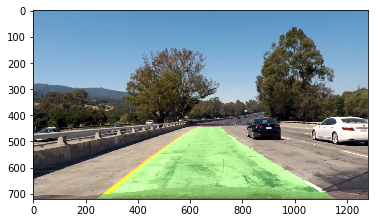

In [97]:
def unwarped_line(warped_image,undist_image,left_fitx,right_fitx):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

   # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (warped_image.shape[1], warped_image.shape[0])) 
    # Combine the result with the original image
    ret = cv2.addWeighted(undist_image, 1, newwarp, 0.3, 0)
    return ret
undist_image = cv2.undistort(image,mtx,dist,None,mtx)
res = unwarped_line(warped_image,undist_image,left_fitx,right_fitx)

plt.imshow(res)

plt.show()




# pipleline

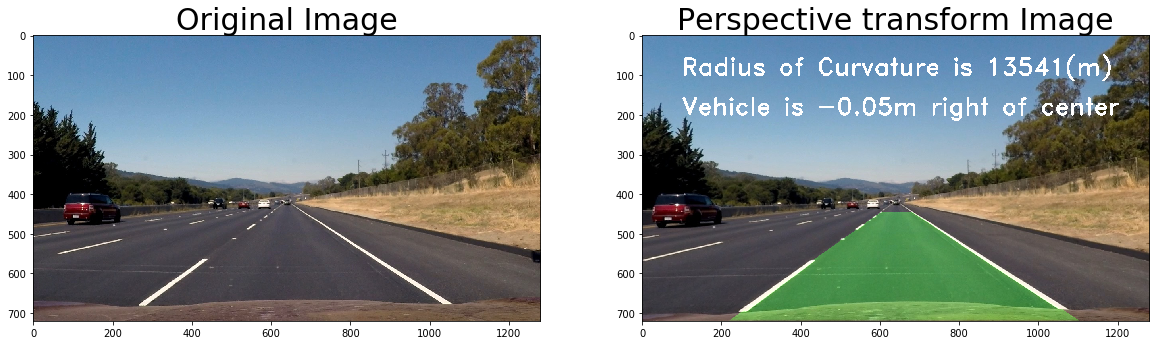

In [111]:
#read image    
image = mpimg.imread('test_images/straight_lines2.jpg')

def pipleline(image,sobel_kernel,orient,sobel_thresh,hls_thresh,nwindows=9,margin=100,minpix=50):
    #undistort image
    undist_image = cv2.undistort(image,mtx,dist,None,mtx)
    #sobelx and hls threshold
    thresh_image = sobel_hls_threshold(undist_image,sobel_kernel=sobel_kernel,orient=orient,sobel_thresh=sobel_thresh,hls_thresh=hls_thresh)
    #warp images
    img_size = (image.shape[1],image.shape[0])
    warped_image = cv2.warpPerspective(thresh_image,M,img_size)   
    #detect line
    left_fit,right_fit,left_fitx,right_fitx = detect_line(warped_image,nwindows=nwindows,margin=margin,minpix=minpix)
    #
    left_curverad,offset = cal_curvature_offset(left_fit,right_fit)
    #unwarped line
    ret = unwarped_line(warped_image,undist_image,left_fitx,right_fitx)
    #display the radius of curvature and offset
    cv2.putText(ret, 'Radius of Curvature is %d(m)'%left_curverad, (100, 100),cv2.FONT_HERSHEY_DUPLEX, 2, (255, 255, 255),4)
    cv2.putText(ret, 'Vehicle is %.2fm right of center'%offset, (100, 200),cv2.FONT_HERSHEY_DUPLEX, 2, (255, 255, 255),4)
    
    return ret

warped_image = pipleline(image,sobel_kernel=3,orient='x',sobel_thresh=(60,150),hls_thresh=(150,255),nwindows=9,margin=100,minpix=50)
# Visualize threshold result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image,cmap = 'gray')
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(warped_image,cmap = 'gray')
ax2.set_title('Perspective transform Image', fontsize=30)

plt.show()

# Test on Videos

In [115]:
# Import everything needed to edit/save/watch video clips
#del clip1
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_image(image):
    result_image = pipleline(image,sobel_kernel=3,orient='x',sobel_thresh=(40,150),hls_thresh=(150,255),nwindows=9,margin=100,minpix=50)
    return result_image

video_output = 'test_video_output/project_video1.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
#clip2 = VideoFileClip('project_video.mp4')
#clip3 = VideoFileClip('project_video1.mp4').subclip(0,2)
clip3 = VideoFileClip('project_video1.mp4')
white_clip = clip3.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video test_video_output/project_video1.mp4
[MoviePy] Writing video test_video_output/project_video1.mp4


100%|█████████████████████████████████████▉| 1260/1261 [02:51<00:00,  7.19it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output/project_video1.mp4 

Wall time: 2min 53s


In [116]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))